<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/PlantVillageDataSet/Test_experiments/plantVilllageVGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import Model,load_model
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.5.0


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Copy of Copy of PlantVillage.tar.gz' 'PlantVillage.tar.gz'

In [ ]:
!tar -xf PlantVillage.tar.gz

In [ ]:
trainPath = '/content/PlantVillage/train'
lists = os.listdir(trainPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(trainPath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
train_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(train_df)


                                                    path   label
0      Grape___healthy/51665d49-a91d-4790-a705-425d3b...   Grape
1      Grape___healthy/ddcf9afc-8a06-4778-8eba-95f8ef...   Grape
2      Grape___healthy/92fbe3df-dc85-4e06-8109-3a14f5...   Grape
3      Grape___healthy/ceb17d89-9a96-4b3b-8fa5-5d4b9e...   Grape
4      Grape___healthy/54ad35bc-3a1a-4cca-bc1b-167888...   Grape
...                                                  ...     ...
43439  Tomato___healthy/e6782c6b-bf00-492d-a30e-966fd...  Tomato
43440  Tomato___healthy/bae543d4-d61d-45e6-aa0c-eaf45...  Tomato
43441  Tomato___healthy/9e0cd9db-f893-4426-b195-5643b...  Tomato
43442  Tomato___healthy/6d7934cb-69fc-48fe-b493-a64b3...  Tomato
43443  Tomato___healthy/cb3ab315-c340-469c-8291-abe02...  Tomato

[43444 rows x 2 columns]


In [ ]:
validationPath = '/content/PlantVillage/val'
lists = os.listdir(validationPath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(validationPath +"/"+folder)
    if(folder != 'background'): 
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
    

validation_df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(validation_df)


                                                    path   label
0      Grape___healthy/c0f3b55f-8078-4e91-aba7-9a187e...   Grape
1      Grape___healthy/9858eca1-78cb-4c9c-9286-ff52a2...   Grape
2      Grape___healthy/666536ee-371f-46c2-b20d-f6fc87...   Grape
3      Grape___healthy/36add77f-5e02-41b0-97e7-b1c14f...   Grape
4      Grape___healthy/caf1a7e7-8f7b-4127-929c-7d9c29...   Grape
...                                                  ...     ...
10856  Tomato___healthy/d247170c-6756-41f0-9074-09190...  Tomato
10857  Tomato___healthy/cf021ef4-2bde-4984-8604-c813c...  Tomato
10858  Tomato___healthy/ed76421e-84e4-408b-a1b3-c6164...  Tomato
10859  Tomato___healthy/a2317e6a-8548-432c-b69f-0f6da...  Tomato
10860  Tomato___healthy/83fa8d6f-4c08-46bf-b4cf-7a33d...  Tomato

[10861 rows x 2 columns]


In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/train/',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/PlantVillage/val/',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 43444 validated image filenames belonging to 14 classes.
Found 10861 validated image filenames belonging to 14 classes.


In [ ]:
print(train_generator.class_indices)

{'Apple': 0, 'Blueberry': 1, 'Cherry_(including_sour)': 2, 'Corn_(maize)': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper,_bell': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}


# **Build VGG19 model**





In [ ]:
class_number=14
def build_model_graph(class_number= class_number):
  base_model = VGG19(include_top=False,weights='imagenet',input_shape=(200, 200, 3))
  x= base_model.output
  x= GlobalAveragePooling2D()(x)
  x= Dropout(0.3)(x)
  x= Dense(256,activation='relu')(x)
  predictions=Dense(class_number,activation='softmax')(x)
  model=Model(base_model.input,predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
______________________________________________________________

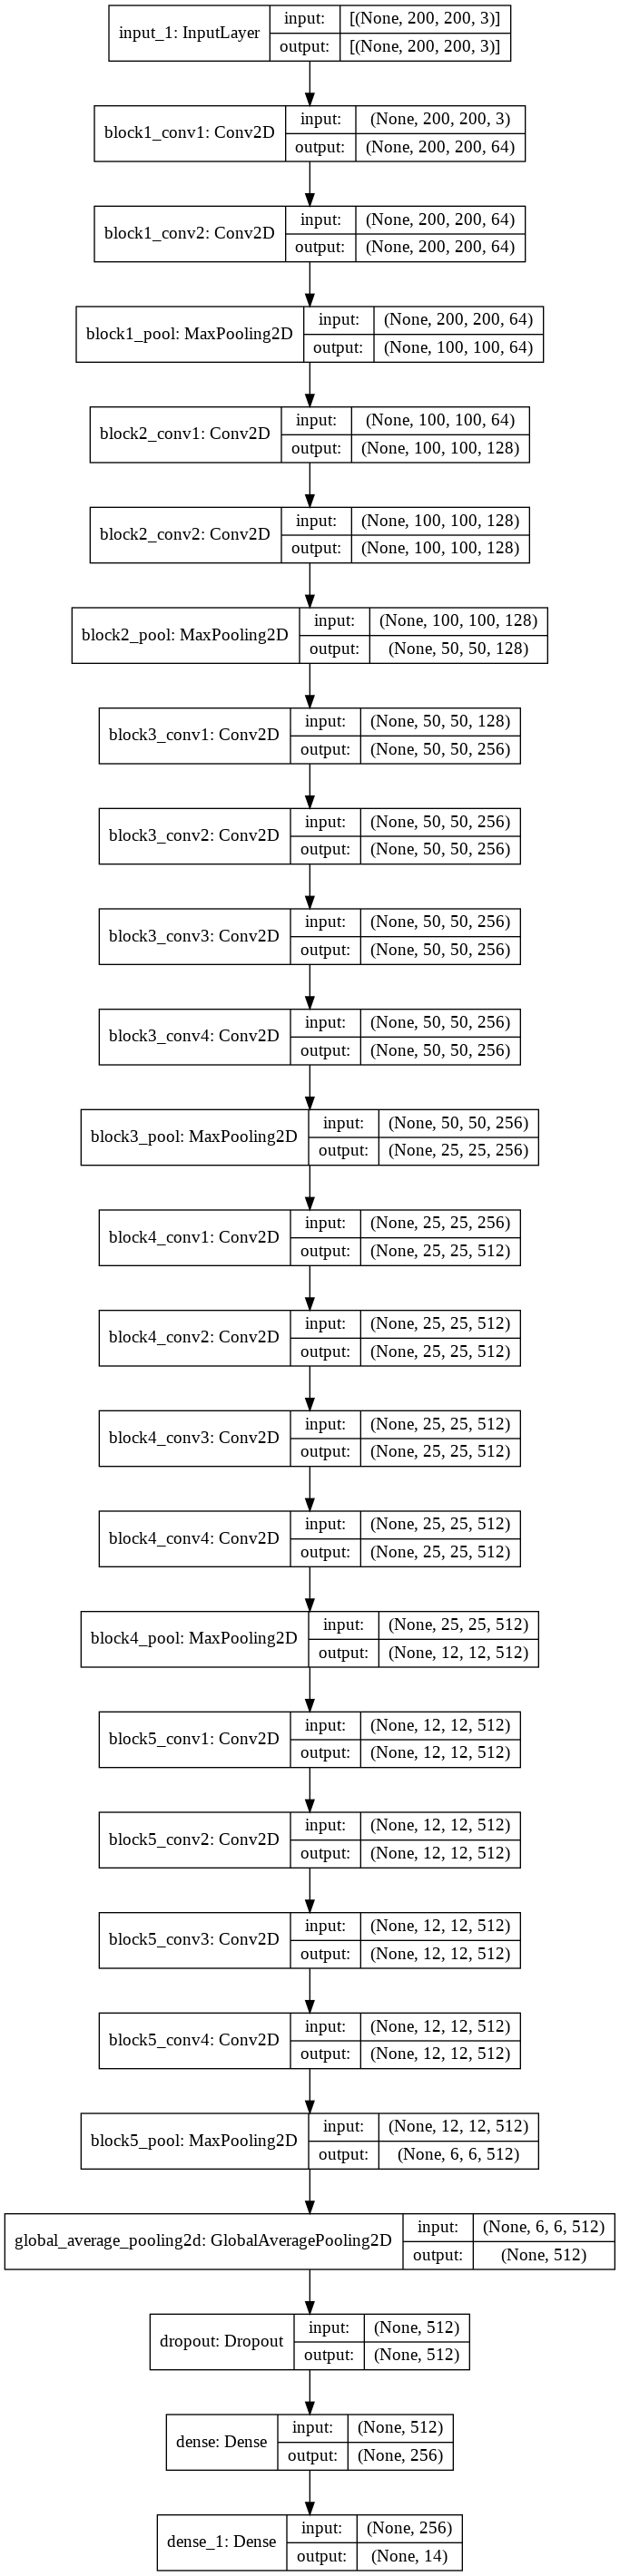

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:

model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
1358/1358 [==============================] - 839s 587ms/step - loss: 0.2811 - accuracy: 0.9140 - val_loss: 0.0428 - val_accuracy: 0.9865
Epoch 2/15
1358/1358 [==============================] - 786s 579ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0321 - val_accuracy: 0.9896
Epoch 3/15
1358/1358 [==============================] - 785s 578ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 0.0346 - val_accuracy: 0.9890
Epoch 4/15
1358/1358 [==============================] - 784s 577ms/step - loss: 0.0158 - accuracy: 0.9953 - val_loss: 0.0121 - val_accuracy: 0.9965
Epoch 5/15
1358/1358 [==============================] - 787s 579ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.0093 - val_accuracy: 0.9973
Epoch 6/15
1358/1358 [==============================] - 787s 579ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0103 - val_accuracy: 0.9969
Epoch 7/15
1358/1358 [==============================] - 785s 578ms/step - loss: 0.0032 - accuracy: 0.9991 - val_

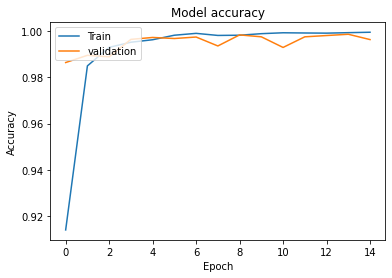

In [ ]:
 import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show() 

In [ ]:
hist = pd.DataFrame(hist.history) 

In [ ]:
VGG19Arch = '/content/drive/MyDrive/VGG19Arch'
os.mkdir(VGG19Arch) 

In [ ]:
hist_csv_file = '/content/drive/MyDrive/VGG19Arch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
target_dir = '/content/drive/MyDrive/VGG19Arch/VGG19Arch'
architecture_name = "VGG19Arch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')